In [7]:
import os
import re
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import string
import spacy
import math
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm

In [8]:
# Load the metatadata about research papers in dataset directory


debug = False
articles = {}
stat = { }
for dirpath, subdirs, files in os.walk('/kaggle/input'):
    for x in files:
        if x.endswith(".json"):
            articles[x] = os.path.join(dirpath, x)        
df = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')

# A brief dataset first to test things
df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45769,4360s2yu,289deae0b2050aa259a05ba84565a4df82fa099a,Elsevier,Personal Protective Equipment: Protecting Heal...,10.1016/j.clinthera.2015.07.007,PMC4661082,26452427.0,els-covid,Abstract Purpose The recent Ebola epidemic tha...,2015-11-01,"Fischer, William A.; Weber, David J.; Wohl, Da...",Clinical Therapeutics,NaN,NaN,True,custom_license,https://doi.org/10.1016/j.clinthera.2015.07.007
45770,66jumbir,21a4369f83891bf6975dd916c0aa495d5df8709e,Elsevier,Viruses and asthma,10.1016/j.bbagen.2011.01.012,PMC3130828,21291960.0,els-covid,Abstract Background Viral respiratory infectio...,2011-11-30,"Dulek, Daniel E.; Peebles, R. Stokes",Biochimica et Biophysica Acta (BBA) - General ...,NaN,NaN,True,custom_license,https://doi.org/10.1016/j.bbagen.2011.01.012
45771,3wk36h9p,NaN,Elsevier,Why the WHO won't use the p-word,10.1016/s0262-4079(20)30474-7,NaN,NaN,els-covid,"There are no criteria for a pandemic, but covi...",2020-03-07,"MacKenzie, Debora",New Scientist,NaN,#5716,False,custom_license,https://doi.org/10.1016/s0262-4079(20)30474-7
45772,0ujw0gak,NaN,WHO,"Communication, transparency key as Canada face...",10.1503/cmaj.1095846,PMC7030882,32071113.0,unk,NaN,2020-02-17,"Glauser, Wendy",Canadian Medical Association Journal,1.953688e+09,#4117,False,NaN,https://doi.org/10.1503/cmaj.1095846


In [10]:
# Only get papers related to coronavirus

VIRUS_REF = ['covid-19', 'covid', 'coronavirus', 'cov-2', 'sars-cov-2', 'sars-cov', 'hcov', '2019-ncov']
def virus_match(text):
    return len(re.findall(rf'({"|".join(VIRUS_REF)})', text, flags=re.IGNORECASE)) > 0

def list_to_string(data, attribute): 
    text = ' '.join([elem['text'] for elem in data[attribute]])
    return text


In [11]:
# Parse all the papers json files and extract abstract and body_text
literature = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    sha = str(row['sha'])
    if sha != 'nan':
        sha = sha + '.json';
        try:
            with open(articles[sha]) as f:
                data = json.load(f)
                paper = {'paper_id': data['paper_id'], 'title': data['metadata']['title']}
                body_text = list_to_string(data, 'body_text')
                abstract = list_to_string(data, 'abstract')
                if virus_match(abstract) | virus_match(body_text):
                    paper['body_text'] = body_text
                    paper['abstract'] = abstract
                    literature.append(paper)
    
        except KeyError:
            pass

100%|██████████| 45774/45774 [06:51<00:00, 111.35it/s]


In [15]:
literature_df = pd.DataFrame(literature)
print(len(literature_df))
literature_df.head()

17783


,paper_id,title,body_text,abstract
0,daf32e013d325a6feb80e83d15aabc64a48fae33,Spatial epidemiology of networked metapopulati...,The term metapopulation was coined by Levins [...,An emerging disease is one infectious epidemic...
1,4da8a87e614373d56070ed272487451266dce919,Bayesian mixture analysis for metagenomic comm...,Metagenomics can be defined as the analysis of...,Deep sequencing of clinical samples is now an ...
2,c41fdb2efd6d61384a92a84cbba3f8233629a41b,The infant airway microbiome in health and dis...,The microbial communities comprising the human...,The nasopharynx (NP) is a reservoir for microb...
3,3461d71f6890f7e5ba53bf168be3945cdb16d901,MERS-CoV recombination: implications about the...,Recombination is an important process which ex...,Recombination is a process that unlinks neighb...
4,01e3b313e78a352593be2ff64927192af66619b5,Title: Viruses are a dominant driver of protei...,The copyright holder for this preprint (which ...,Viruses interact with hundreds to thousands of...


## Does entity recognition works to find time frames or useful info?

In [0]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(literature_df['body_text'])
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

## Group and query papers by similarity

### Comparing articles similarity

In [0]:



# count vectorizer convert a collection of documents into a matrix of word frecuencies
# max_df param is set the max treshold to ignore words wich frequency pass this value.
# stop_worlds to remove stop_words
# ngrams_range set the tuple of ngrams, in our case we want tuples (word1, word2)

from nltk.stem.snowball import SnowballStemmer
analyzer = CountVectorizer().build_analyzer()
stemmer = SnowballStemmer("english")

def stemming(doc):
    doc=doc.lower()
    return str.join(" ", [stemmer.stem(w) for w in analyzer(doc)])

%time literature_df['stemmized'] = literature_df['body_text'].apply(lambda doc: stemming(doc))

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from scipy.spatial import distance
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import ipywidgets as widgets

from IPython.display import Image
from IPython.display import display, HTML

In [16]:
cv = CountVectorizer(max_df=0.95, min_df=0.01, stop_words='english')
%time word_count = cv.fit_transform(literature_df.body_text)
tfidf_tr = TfidfTransformer(smooth_idf=True, use_idf=True)
%time tfidf_tr.fit_transform(word_count)

CPU times: user 1min 44s, sys: 638 ms, total: 1min 45s
Wall time: 1min 45s
CPU times: user 1.36 s, sys: 112 ms, total: 1.47 s
Wall time: 1.48 s


<17783x11726 sparse matrix of type '<class 'numpy.float64'>'
	with 14412712 stored elements in Compressed Sparse Row format>

In [17]:

def get_word_vector(document):
    word_vector = tfidf_tr.transform(cv.transform([document]))
    return word_vector 

%time literature_df['word_vector'] = literature_df.body_text.apply(get_word_vector)

CPU times: user 2min 13s, sys: 136 ms, total: 2min 13s
Wall time: 2min 13s


In [18]:

def show_word_cloud(word_vector):
    cloud = WordCloud(background_color='white',
        width=500,
        height=500,
        max_words=20,
        colormap='tab10',
        prefer_horizontal=1.0)
    word_frequency = dict(get_words_with_value(word_vector))
    cloud.generate_from_frequencies(word_frequency)
    plt.gca().imshow(cloud)
    plt.gca().axis('off')

feature_names = cv.get_feature_names()
def get_words_with_value(word_vector):
    return sorted([(feature_names[ind], val) for ind, val in zip(word_vector.indices, word_vector.data)], key=lambda x: x[1], reverse=True)

In [22]:

def calculate_distance_between_words_vectors(query_indices, search_vec, document_vector):
    document_vec = document_vector[0, query_indices].toarray()
    return distance.euclidean(search_vec, document_vec)

def calculate_related_documents(query, max_documents_comparison):    
    query_vector = get_word_vector(query)
    query_indices = query_vector.indices
    query_vector_array = query_vector[0, query_indices].toarray()
    distance_idx = literature_df.apply(lambda x: calculate_distance_between_words_vectors(query_indices, query_vector_array, x.word_vector), axis=1)
    
    relevant_indexes = distance_idx.sort_values().head(max_documents_comparison).index 
    result_columns = ["paper_id", "word_vector"]
    
    result = literature_df[result_columns].iloc[relevant_indexes].fillna("")
    return result

In [26]:

def display_word_frecuencies_distances(df_result):
    display_columns = ["paper_id", "word_vector"]
    display(df_result[display_columns].reset_index(drop=True))
    rows = math.ceil(len(df_result)/3)
    plt.rcParams["figure.figsize"] = (20,15)
    for i in range(len(df_result)):
        row = df_result.iloc[i]
        plt.subplot(rows, 3, i+1)
        show_word_cloud(row.word_vector)
        paper_id = f'{row.paper_id[:5]}...{row.paper_id[-5:]}'

        plt.title(f'Paper {paper_id}', fontsize=10)
    plt.show()

def compare_distances_and_show(questionary):
    for question in questionary:
        display(HTML(f"<h3>{question}<h3>"))
        topic_result = calculate_related_documents(question, 6)
        display_word_frecuencies_distances(topic_result)

,paper_id,word_vector
0,fc5352a50f90e04d8c5ed64243f863417133e4dc,"(0, 11711)\t0.042974503073963284\n (0, 1168..."
1,3e43db4bbfa0307b42810ceb2b3cd07e2c321e2b,"(0, 11696)\t0.03645419162026805\n (0, 11638..."
2,d09c0f71b1a404a592d0dcad2c3409d43c375f99,"(0, 11696)\t0.012578363800001288\n (0, 1168..."
3,e08ff7855eaa0c9d0bb785dcffc24e65910b7184,"(0, 11711)\t0.018020659398607527\n (0, 1171..."
4,56452dcbb28bcaaada2c96aaee646a1c27bc8230,"(0, 11711)\t0.009848381499998017\n (0, 1167..."
5,f24d3b4b4af138be06b7452b7acefc8948bc1056,"(0, 11696)\t0.023688891892183532\n (0, 1166..."


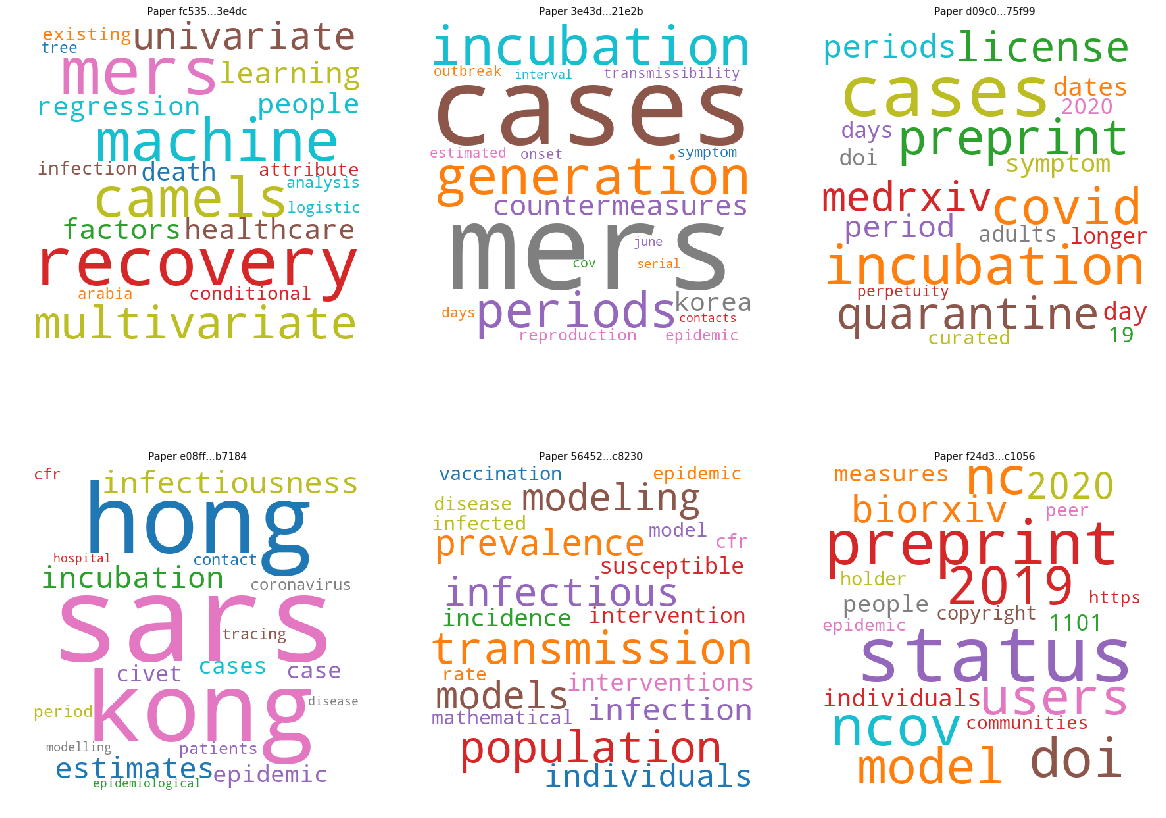

,paper_id,word_vector
0,b5cc9beeba0814dc5d529ef3f886aa995f2d1ef5,"(0, 11673)\t0.03171105341977393\n (0, 11594..."
1,f357f47521ed41c7f2abb2c41fb3fab57cd37a51,"(0, 11689)\t0.026660627888191995\n (0, 1168..."
2,916f40590e69b6004914559b3e6a8b8a073734b3,"(0, 11673)\t0.011231504501933757\n (0, 1167..."
3,5b7753b6a659e6afa0a46fe171a372e682b07010,"(0, 11688)\t0.008511882585724094\n (0, 1168..."
4,c6568dd2c4fdc50f1614e96ed78f5fe37f3180ed,"(0, 11687)\t0.00862275382031716\n (0, 11671..."
5,8c6ca63f974a55bcab6f773fc9cda85c938b93eb,"(0, 11687)\t0.011476566409438714\n (0, 1168..."


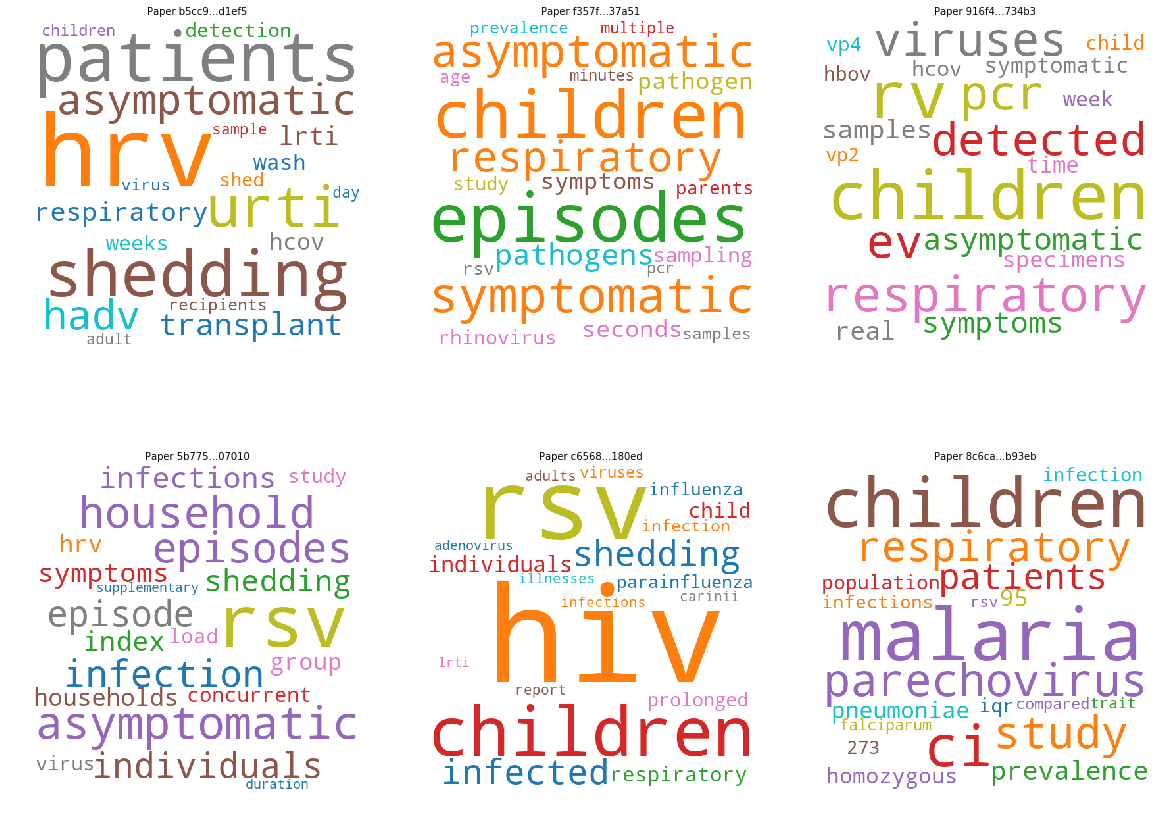

,paper_id,word_vector
0,19899d297b92d28185836daaa6e9505d0cf1388e,"(0, 11725)\t0.007311160800067287\n (0, 1170..."
1,40a57ffe8adda95a13b552b630b13d76344f666c,"(0, 11724)\t0.034029750011776695\n (0, 1170..."
2,70e2b820b3d2056eb90ac0e11ac230267fd0d7e8,"(0, 11628)\t0.02329886557135085\n (0, 11595..."
3,13f6bc615450f0470c2a265e0a2c8506f0b05048,"(0, 11725)\t0.05172973132278513\n (0, 11708..."
4,60e996c706b7ab55904212657f30479160c4fe1e,"(0, 11679)\t0.004669225246315209\n (0, 1167..."
5,4687bf954d778ff22416b202abeafe5012f3a88f,"(0, 11712)\t0.006953505446700969\n (0, 1171..."


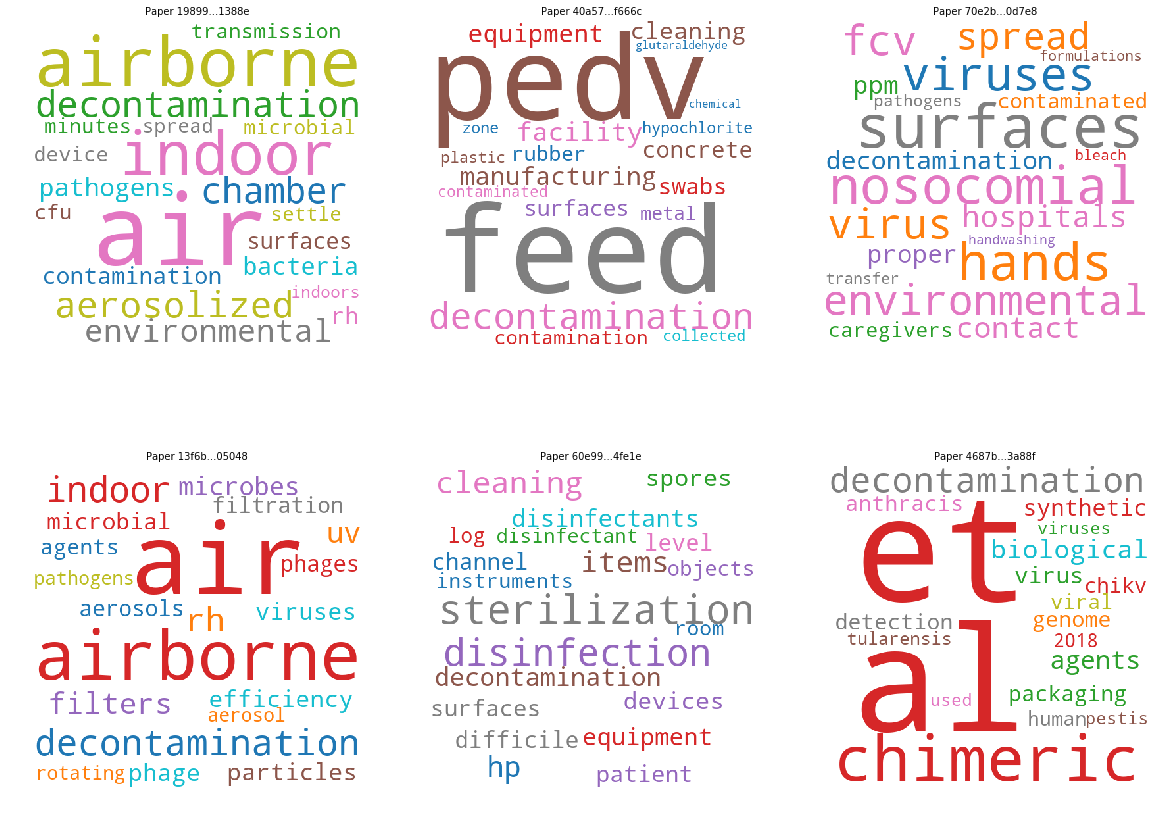

,paper_id,word_vector
0,580cbd605ccd8a2ba964488b5a5adb258adcf42a,"(0, 11724)\t0.01984372576725692\n (0, 11679..."
1,a48bc1745fa15021b49890385022bbe7c4b1076b,"(0, 11660)\t0.03663073099419514\n (0, 11629..."
2,3677789674e47d9e9b35f87c659430e5295370e9,"(0, 11711)\t0.009160146678237698\n (0, 1170..."
3,b121a4b1dc6d8e513631edeb11421f20aad79106,"(0, 11724)\t0.022823156485330745\n (0, 1172..."
4,335c14ac989e0aef609bb1bd1e117fcdf662b4ea,"(0, 11724)\t0.04969258083389405\n (0, 11534..."
5,6dd2ed6685cf7be8b496fa8f100866f70f84b724,"(0, 11718)\t0.016880648194801704\n (0, 1163..."


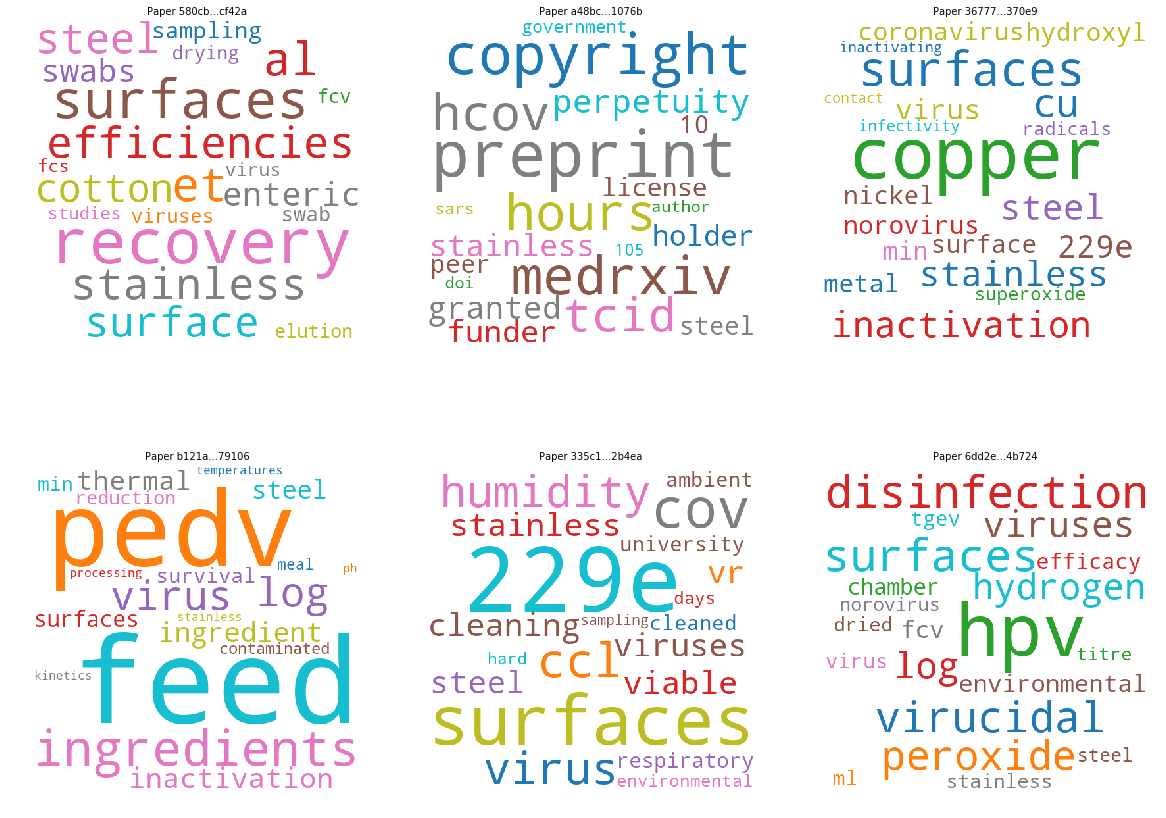

In [29]:
task1 = ["Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery?", 
               "Prevalence of asymptomatic shedding and transmission (e.g., particularly children)", 
               "Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).", 
               "Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic)."]

compare_distances_and_show(task1)

,paper_id,word_vector
0,fe27b86b73d62c98bff24f79470fdfd479427807,"(0, 11711)\t0.031972750892494246\n (0, 1168..."
1,d91c2ac8b93129970cedf7baaf3688e8026c2ca4,"(0, 11725)\t0.15493049772709827\n (0, 11723..."
2,89f41c87c8849ce37e609c1010087291a4679a37,"(0, 11711)\t0.009001142481129298\n (0, 1170..."
3,fd6163a04c4ac0100a7c9be19def78d2171eac47,"(0, 11698)\t0.007214530362292437\n (0, 1169..."
4,a4d06a5b2f6f7b1071b36b9ba083e757d0f4ec97,"(0, 11693)\t0.01675507465710817\n (0, 11692..."
5,d27a33853d4631f93853f0d850bc06d8d1d833c6,"(0, 11660)\t0.16220173955712\n (0, 11629)\t..."


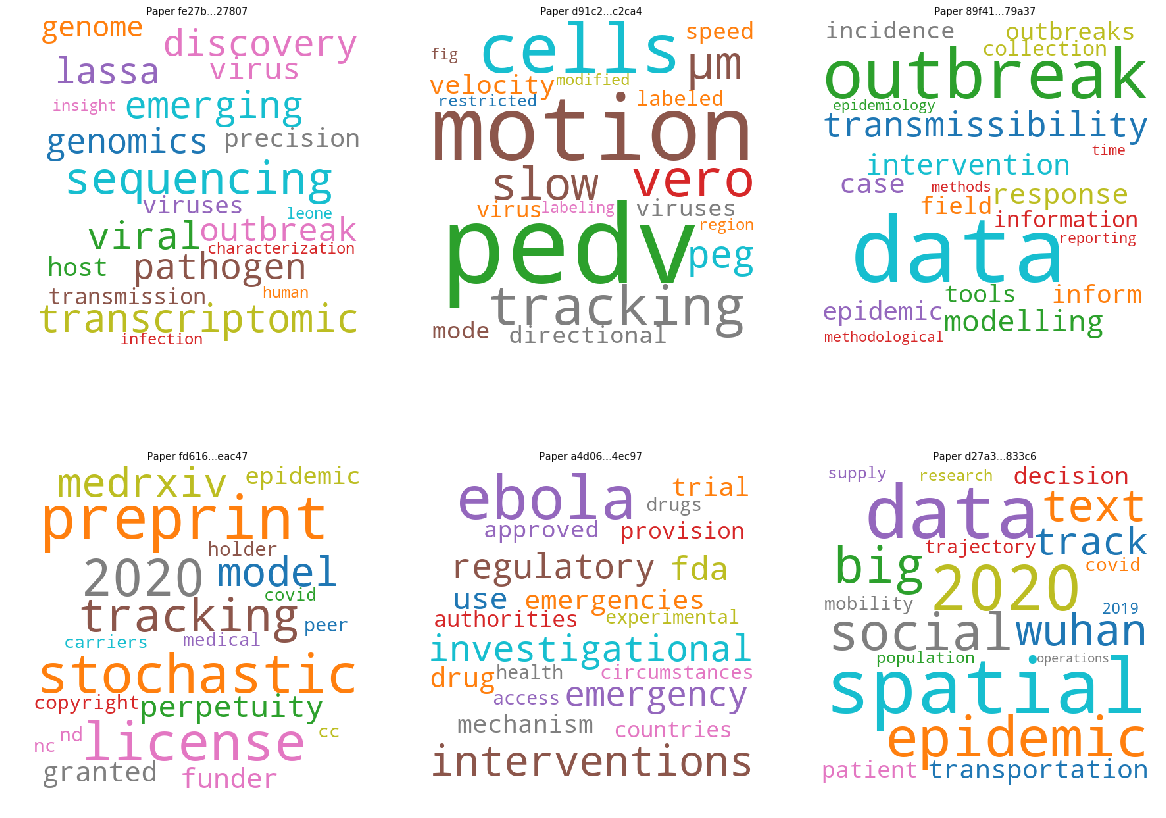

,paper_id,word_vector
0,23696844593c72dd8c4d74607ff26049336fe9b0,"(0, 11687)\t0.005885583166094394\n (0, 1167..."
1,519d5fa432c696fd94690fbffeb3d566a247019c,"(0, 11709)\t0.023295501738486355\n (0, 1170..."
2,a95c035b57ab604840a84a23ec7ba8f42b7b25d1,"(0, 11711)\t0.007590007856383369\n (0, 1170..."
3,f2af8027b6801850481d09ad0d4c5eb8e31c7d7f,"(0, 11679)\t0.0053226036619153086\n (0, 116..."
4,90d54e33891390c4539182390d2976123d5ddc2a,"(0, 11711)\t0.042548261608714964\n (0, 1167..."
5,9b5b4f2e304b7baa7702dfeba1d7725e7d3fb6ca,"(0, 11708)\t0.01282525713629651\n (0, 11707..."


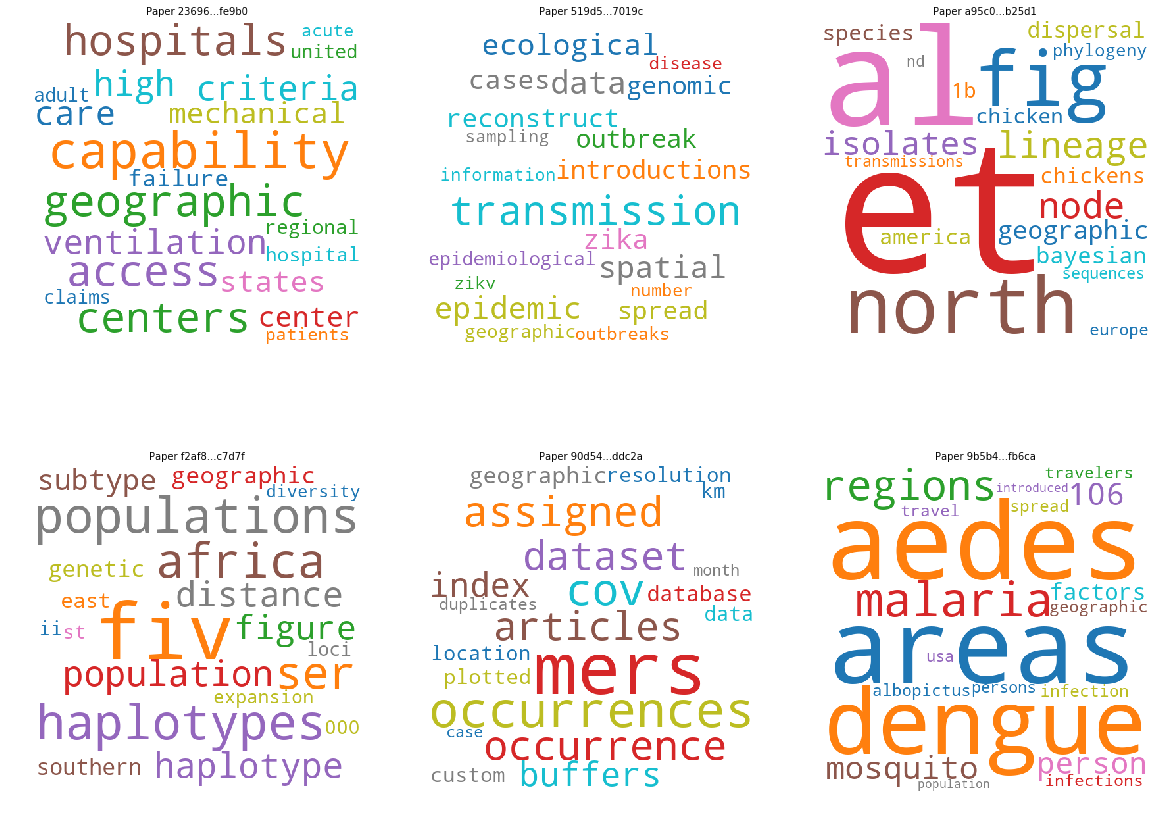

,paper_id,word_vector
0,f427623ad5c9e1e5308867f7d0507007261bcdeb,"(0, 11690)\t0.014393264781708109\n (0, 1168..."
1,88c39c6f8173c91f84fee2d3c382ebbf7d655b11,"(0, 11711)\t0.3134782525430777\n (0, 11703)..."
2,95cc317541d97e3dbaa1662894fdbed842098910,"(0, 11724)\t0.01829318837148474\n (0, 11714..."
3,b406fb73bb91dd7aed57b8187b69a5db7e83bd85,"(0, 11711)\t0.11398310711672334\n (0, 11709..."
4,ae267a98af103856a22932cac54e9208b34da846,"(0, 11696)\t0.005504878138136562\n (0, 1168..."
5,eb88125e0384bc94499e00b623b18a7d033d0c1a,"(0, 11711)\t0.09902189901681709\n (0, 11708..."


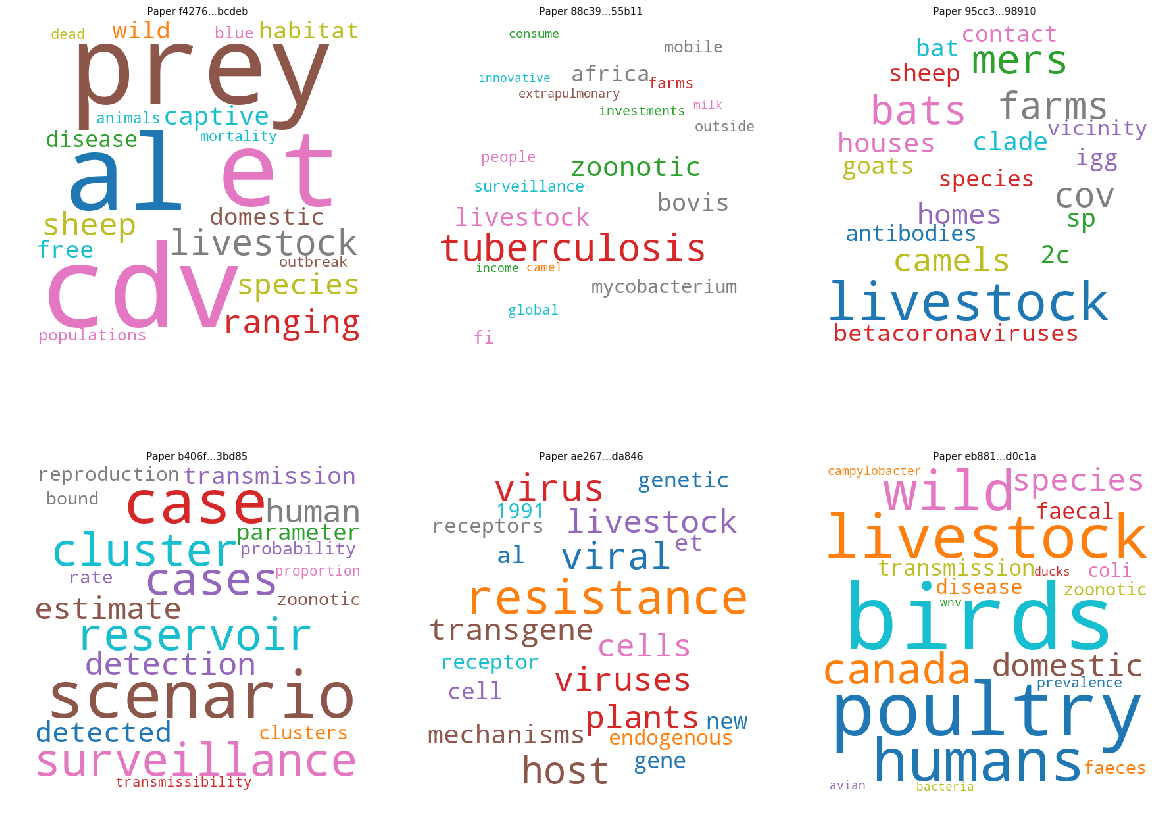

,paper_id,word_vector
0,59e6dfead3d50788eb626a32f19305afce88bc63,"(0, 11688)\t0.005410489114879248\n (0, 1168..."
1,975a8b4abe4cc0181522e859a92c5ddc22f50c29,"(0, 11689)\t0.024420595151507782\n (0, 1168..."
2,3322e82fcffb7cfd2de8b8b9db7b86340fe5b4b0,"(0, 11711)\t0.005014671371438304\n (0, 1169..."
3,ee1b5a9618dcc4080ed100486cedd0969e80fa4d,"(0, 11711)\t0.00789137395294454\n (0, 11710..."
4,88c6892230189edaea262895b14a15b1c6032041,"(0, 11711)\t0.0066775273901494\n (0, 11707)..."
5,d0812df257e4fb4f247f98f53298adea60585674,"(0, 11686)\t0.008465216861104793\n (0, 1168..."


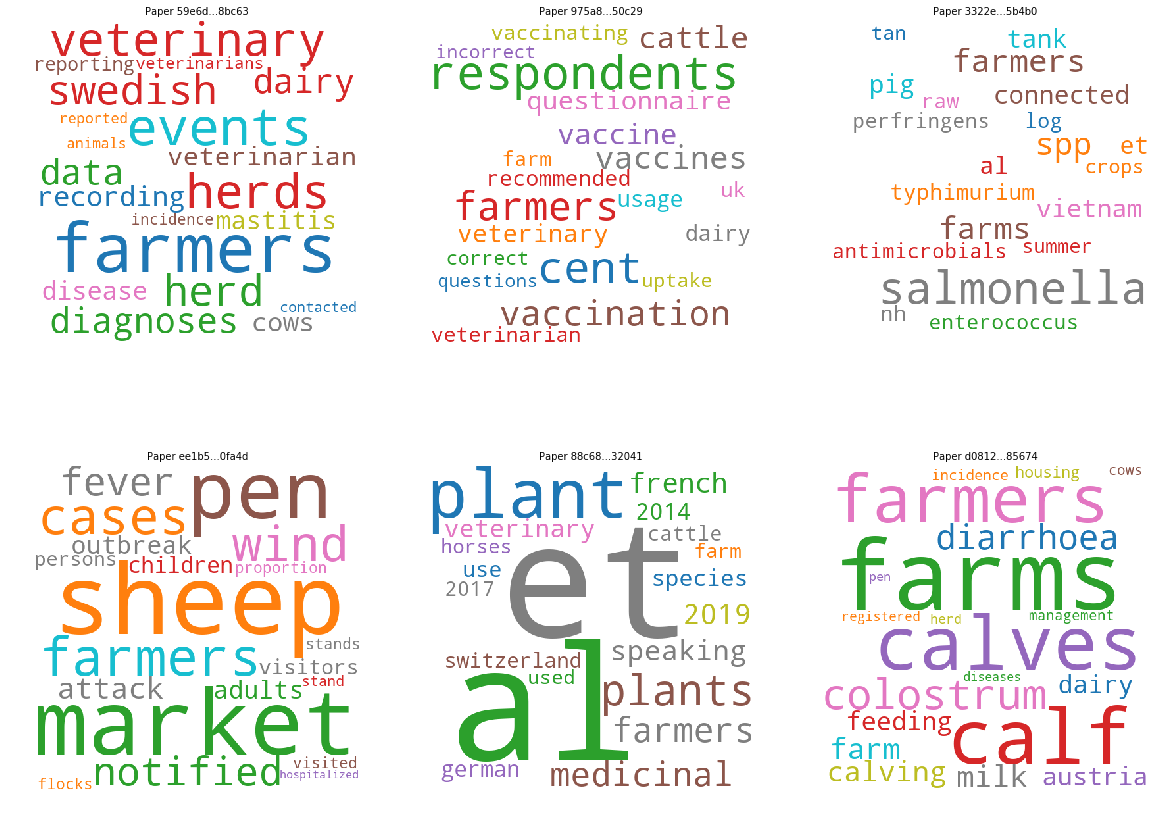

In [28]:
task2 = ["Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.",
"Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.",
    "livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.",
" whether farmers are infected, and whether farmers could have played a role in the origin." ]

compare_distances_and_show(task2)

In [30]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=10,
                          random_state=0,
                          batch_size=100,
                          max_iter=50)

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.4)
%time transform = tfidf_vectorizer.fit_transform(literature_df['body_text'])
%time kmeans.fit(transform)

CPU times: user 1min 52s, sys: 613 ms, total: 1min 53s
Wall time: 1min 53s
CPU times: user 489 ms, sys: 0 ns, total: 489 ms
Wall time: 499 ms


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=50, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=0,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [70]:

print("Centroid of clusters: \n")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(10):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :30]]
    print("Cluster {}: {} \n".format(i, ' '.join(top_ten_words)))

Centroid of clusters: 

Cluster 0: cells were cell expression fig virus infection protein we viral infected 10 figure anti using which these ml immune proteins activity rna replication after also induced response antibody been gene 

Cluster 1: virus viruses influenza viral infection been human has were can disease which these respiratory it host infections cells may al also no cell such immune other species but against more 

Cluster 2: sars were patients protein virus we cells infection 10 which who fig these viral respiratory been it al has cases human had et coronavirus other disease after all also may 

Cluster 3: et al were virus protein cells rna been fig which viral these infection has no it also using viruses pcr cell 10 sequence proteins may strains samples other can gene 

Cluster 4: were samples pcr virus study respiratory using 10 viruses positive viral we all infection strains detection these used detected clinical which table influenza ml been rna al et between other 

C

In [73]:
task2 = ["Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.",
"Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.",
    "livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.",
" whether farmers are infected, and whether farmers could have played a role in the origin." ]

predictions = [kmeans.predict(tfidf_vectorizer.transform([task])) for task in task2]
for i in range(0, len(task2)):
    print(f'Query: {task2[i]}')
    print(f'Prediction: {predictions[i]}')



Query: Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.
Prediction: [1]
Query: Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.
Prediction: [9]
Query: livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.
Prediction: [9]
Query:  whether farmers are infected, and whether farmers could have played a role in the origin.
Prediction: [9]
